In [1]:
import numpy as np
import matplotlib.pyplot as plt
import random
from collections import defaultdict
import itertools
import operator
import time

# EXERCISE 1: Tabular Indendent Q-learning
In this exercise, you will see how multiple agents can learn behaviours simultaneously with reinforcement learning.

In the following code block, we define a Predator-Prey environment. The predators are agents which will move in a toroidal grid, attempting to catch a prey. Capture is successful when a predator moves onto the prey, and another predator is adjacent to the prey to support it.

If the capture fails, predators move onto each other, or capture is successful, the predators are moved to random positions.

This environment is continuing by default, so there are no terminal states.

In [2]:
class PredPrey:
    def __init__(self, n_agents, h, w):
        self.n_agents = n_agents
        self.h = h
        self.w = w
        self.n_cells = h*w
        self.pred_pos = [(0,0) for _ in range(n_agents)]
        self.prey_pos = np.zeros((2))
        # seed control for reproducibility
        self.rng = random.Random(0)

        # Reward function parameters
        self.living_reward = 0.0
        self.pred_stack_reward = -10
        self.capture_reward = 37.5
        self.fail_capture_reward = -25

        # Prey parameters
        self.possible_prey_actions = ['north', 'west', 'south', 'east']
        self.prey_move_prob = 0.8
        
        # Every agent can take one of these actions at each timestep.
        self.possible_agent_actions = ('north','west','south','east','stay')
        
        """
        A joint action is a tuple with each agent's actions.
        This property should be the list of all possible joint actions:
        """
        self.possible_joint_actions = list(itertools.product(self.possible_agent_actions, repeat=self.n_agents))
        
        # Define the directions
        self.action_deltas = {'north': (-1, 0), 'west': (0, -1), 'south': (1, 0), 'east': (0, 1), 'stay': (0,0)}
        self.reset()
    
    def get_reward(self):
        if sum([(p == self.prey_pos) for p in self.pred_pos]) == 1:
            # capture attempted, exactly one pred moved on prey
            if any([np.abs(np.array(p) - np.array(self.prey_pos)).sum() == 1 for p in self.pred_pos]):
                # at least one supporting predator
                self.reset()
                return self.capture_reward
            else:
                self.reset(predator_only=True)
                return self.fail_capture_reward
        elif len(self.pred_pos) != len(set(self.pred_pos)):
            # stacked up predators
            self.reset(predator_only=True)
            return self.pred_stack_reward
        else:
            return self.living_reward
    
    def reset(self, predator_only=False):
        positions = self.rng.sample(range(self.n_cells), self.n_agents + 1)
        if not predator_only:
            self.prey_pos = np.unravel_index(positions[0], (self.h, self.w))
        self.pred_pos = [np.unravel_index(p, (self.h, self.w)) for p in positions[1:]]
        return self.get_state()
    
    def _move(self, pos, delta):
        return ((pos[0] + delta[0]) % self.h, (pos[1] + delta[1]) % self.w)
    
    def step(self, joint_action):
        for a in range(self.n_agents):
            self.pred_pos[a] = self._move(self.pred_pos[a], self.action_deltas[joint_action[a]])
        reward = self.get_reward()
        if self.rng.random() < self.prey_move_prob:
            # Move prey to a random free adjacent space
            random.shuffle(self.possible_prey_actions)
            for prey_action in self.possible_prey_actions:
                possible_prey_pos = self._move(self.prey_pos, self.action_deltas[prey_action])
                if possible_prey_pos not in self.pred_pos:
                    self.prey_pos = possible_prey_pos

        return (self.get_state(), reward, False, {})
    
    def get_state(self):
        prey_x, prey_y = self.prey_pos
        return tuple([ ( (pred_y - prey_y)%self.h, (pred_x - prey_x)%self.w ) for (pred_x, pred_y) in self.pred_pos])
    
    def display(self):
        grid = np.zeros((self.h, self.w))
        for a, pos in enumerate(self.pred_pos):
            grid[pos] = a + 1
        grid[self.prey_pos] = -1
        print(grid)

To get familiar with the environment, play around with the code blocks below or make your own. Choose your own actions to control the predators. Observe how the predators and prey move, and how the agents must coordinate to capture the prey.

In [3]:
# Make a predator-prey environment
env = PredPrey(2, 4, 4)
env.display()

[[ 0.  0.  0.  0.]
 [ 0.  0.  2.  0.]
 [ 0.  0.  0.  0.]
 [-1.  0.  0.  1.]]


In [4]:
s, r, terminal, _ = env.step(("north", "south"))
print("Reward ", r)
env.display()

Reward  0.0
[[ 0.  0.  0.  0.]
 [ 0.  0.  0.  0.]
 [ 0.  0.  2.  1.]
 [-1.  0.  0.  0.]]


## Questions & Answers on Joint Action Space and State Space

**Question**: What is the size of the joint action space?

* **Size**: With **5** possible actions per agent and $N$ agents, the joint action space has a size of **$5^N$**.

**Question**: How many possible states are there, given the height and width of the grid $(h,w)$ and the number of agents $N$? Assume a single prey always. Predators and prey are not allowed to overlap.

| Component | Calculation (Total Configurations) |
| :--- | :--- |
| **Prey Positions** | $h \times w$ |
| **Predator Positions** | $P(h \times w - 1, N)=\dfrac{(h w - 1)!}{(h w - 1 - N)!}$ |

**Total Theoretical States ($\mathbf{S_{total}}$)**:

$$
S_{\text{total}}=(h \times w)\times P(h \times w - 1, N).
$$

**Question**: Look at `env.get_state()`. How is the state represented? Does this correspond to the number of states you were expecting? Did the position of the prey matter? Could we reduce the state-action space further—are any state-action pairs equivalent with each other in terms of their value?

* **State Representation**: The state encodes only the **prey-relative** predator offsets (agents are **labeled**).
    * **Prey Position**: The absolute prey position **does not matter**.

* **State Space Size**: The number of **reachable relative states** is **exactly** $P(h \times w - 1, N)$ (no $(0,0)$ offsets; no overlaps).
    This equals $\dfrac{S_{\text{total}}}{h \times w}$.

* **Further Reduction (Symmetries)**:
    * If we **canonicalize** the predator tuple (e.g., sort offsets so agents become exchangeable), the count becomes $\binom{h \times w - 1}{N}$.
    * Otherwise, torus symmetries can guide **parameter sharing**, but they do not change the enumerated state count.

The following code-block contains a plotting function that keeps track of the experimental results. Re-executing this block will clear all previous experiments from the plots; otherwise it can be ignored.

In [5]:
plot_data = {}
plt.clf()
plt.close()

def plot_all_results(plot_std=False):
    colors = ['orange', 'red', 'magenta', 'blue', 'green', 'black', 'c']
    fig, ax = plt.subplots(1, 2, figsize=[14, 5])
    # Plot the performance
    for exp_id, exp in enumerate(plot_data.keys()):
        data = plot_data[exp]
        plot_ts = data["t"]
        plot_rewards = data["captures"]
        plot_table_sizes = data["table_size"]
        gca = ax[0]
        for ts, rewards in zip(plot_ts, plot_rewards):
            if rewards is not None:
                gca.plot(ts, rewards, label=exp, color=colors[exp_id%len(colors)])
        gca.set_xlabel("Env steps")
        gca.set_ylabel("Captures / 1000 steps")
        gca = ax[1]
        for ts, table_sizes in zip(plot_ts, plot_table_sizes):
            gca.plot(ts, table_sizes, label=exp, color=colors[exp_id%len(colors)])
        gca.set_xlabel("Env steps")
        gca.set_ylabel("Size of Q Table")
        gca.set_yscale("log")
        gca.legend()
    plt.show()

## TASK 1a: Another Tabular Q-Learner
Familiarise yourself with the implementation of a tabular Q-Learner below.

**Question**: Look at the calculation of the greedy choice line. Is there a problem with this implementation?

In [6]:
class TabularQLearner:
    """ Tabular Q-learning agent. """
    gamma = 0.9
    learn_rate = 0.1

    def __init__(self, actions_list):
        self.name = "SingleLearner"
        self.actions_list = actions_list
        self.q_table = defaultdict(lambda: {a: 0.0 for a in actions_list})
        
    def q_values(self, state):
        return self.q_table[state]

    def sample(self, state, eps):
        """ Sample an action epsilon-greedy. """
        if np.random.uniform(0, 1) < eps:  # Random choice
            action = random.choice(list(self.q_table[state].keys()))
        else:  # Greedy choice with random tie-breaking
            q = self.q_table[state]
            max_q = max(q.values())
            best_actions = [a for a, v in q.items() if v == max_q]
            action = random.choice(best_actions)
        return action

    def value(self, state):
        """ Returns the value of the state. """
        return max(self.q_table[state].values())

    def update(self, state, action, reward, next_state, done):
        """ The agent 'learns' from the given transition. """
        not_done = 0 if done else 1
        td_error = reward + not_done * self.gamma * self.value(next_state) - self.q_table[state][action]
        self.q_table[state][action] = self.q_table[state][action] + self.learn_rate * td_error
    
    def stats(self):
        return {"table_size": len(self.q_table.keys())*len(self.actions_list)}

## TASK 1b: the experiment 
Familiarize yourself with the basic loop of the RL experiment.

**Question:** There is an option to disable training during a phase of zero-epsilon evaluation. Do we technically need to disable training durning this phase? Why / why not?

No, technically it's not strictly necessary to set $\text{eps}=0$ as it only enforces greedy execution, which doesn't affect the visible behavior.However, for faithful and reproducible evaluation, we must set $\text{training}=\text{False}$. If training continues during evaluation, the policy changes mid-measurement, introducing bias, extra variance, and making comparisons invalid

In [7]:
def run_steps(env, agent, n_steps, eps, training=True):
    state = env.get_state()
    all_rewards = []
    all_captures = []
    # Run the environment continuously -- there are no terminal states in the default pred-prey
    for step in range(n_steps + 1):
        current_state = state
        action = agent.sample(current_state, eps)
        state, reward, done, _ = env.step(action)
        all_rewards.append(reward)
        all_captures.append(reward > 0)
        if training:
            agent.update(current_state, action, reward, state, done)
    return all_rewards, all_captures

def run_experiment(env, agent, num_epochs=20, steps_epoch=int(5e4), plot_rewards=True):
    steps_eval = int(2e4)
    eps = 0.1 # epsilon for epsilon-greedy exploration
    # Set seeds (for reproduceability)
    np.random.seed(0)
    random.seed(0)
    print(f'----- Start Learning with {agent.name}, {env.n_agents} agents -----')
    ts, all_eval_captures, all_train_captures, all_table_sizes = [], [], [], []
    for epoch in range(1, num_epochs + 1):
        t_start = time.time()
        env.reset()
        train_rewards, train_captures = run_steps(env, agent, steps_epoch, eps, training=True)
        env.reset()
        eval_rewards, eval_captures = run_steps(env, agent, steps_eval, 0.0, training=False)
        t_finish = time.time()
        stats = agent.stats()
        print(f'Epoch {epoch}: time = {t_finish-t_start:.2f}')
        print(f'Train: reward = {np.mean(train_rewards):.2f} -- Captures/1000 = {np.sum(train_captures)/(steps_epoch/1000):.2f}')
        print(f'Eval: reward = {np.mean(eval_rewards):.2f} -- Captures/1000 = {np.sum(eval_captures)/(steps_eval/1000):.2f}')
        print(stats)
        ts.append(epoch*steps_epoch)
        all_train_captures.append(np.sum(train_captures)/(steps_epoch/1000))
        all_eval_captures.append(np.sum(eval_captures)/(steps_eval/1000))
        all_table_sizes.append(stats["table_size"])
#   Plotting stuff
    exp_name = agent.name + f'-{env.n_agents}-{env.h}x{env.w}'
    if not plot_rewards:
        all_train_captures = None
    if exp_name not in plot_data:
        plot_data[exp_name] = {
            "t": [ts], "captures": [all_train_captures], "table_size": [all_table_sizes]
        }
    else:
        plot_data[exp_name]["t"].append(ts)
        plot_data[exp_name]["captures"].append(all_eval_captures)
        plot_data[exp_name]["table_size"].append(all_table_sizes)

## TASK 1c: test the tabular agent 
Run the experiment with a TabularQLearner. This is a single learner that controls all agents jointly as a puppeteer.

----- Start Learning with SingleLearner, 2 agents -----
Epoch 1: time = 2.56
Train: reward = -0.20 -- Captures/1000 = 0.40
Eval: reward = -0.13 -- Captures/1000 = 1.50
{'table_size': 240200}
Epoch 2: time = 2.66
Train: reward = 0.02 -- Captures/1000 = 5.54
Eval: reward = 0.49 -- Captures/1000 = 18.25
{'table_size': 242425}
Epoch 3: time = 2.64
Train: reward = 0.66 -- Captures/1000 = 24.60
Eval: reward = 0.49 -- Captures/1000 = 14.85
{'table_size': 242675}
Epoch 4: time = 2.68
Train: reward = 1.19 -- Captures/1000 = 38.84
Eval: reward = 2.07 -- Captures/1000 = 62.35
{'table_size': 242725}
Epoch 5: time = 2.50
Train: reward = 1.16 -- Captures/1000 = 37.06
Eval: reward = 1.79 -- Captures/1000 = 56.15
{'table_size': 242825}
Epoch 6: time = 3.15
Train: reward = 1.04 -- Captures/1000 = 33.88
Eval: reward = 1.87 -- Captures/1000 = 59.75
{'table_size': 242900}
Epoch 7: time = 2.74
Train: reward = 1.21 -- Captures/1000 = 39.88
Eval: reward = 2.07 -- Captures/1000 = 59.70
{'table_size': 242925}


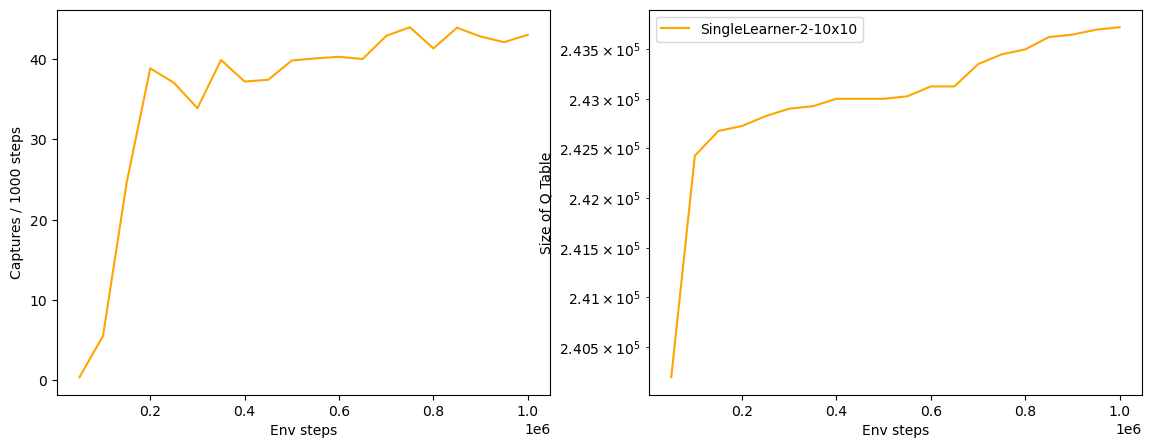

In [8]:
env = PredPrey(2, 10, 10)
run_experiment(env,
               TabularQLearner(env.possible_joint_actions),
               num_epochs=20, plot_rewards=True)
plot_all_results()

----- Start Learning with SingleLearner, 2 agents -----
Epoch 1: time = 3.10
Train: reward = 2.25 -- Captures/1000 = 88.40
Eval: reward = 3.02 -- Captures/1000 = 110.25
{'table_size': 5975}
Epoch 2: time = 3.87
Train: reward = 2.64 -- Captures/1000 = 101.88
Eval: reward = 3.30 -- Captures/1000 = 123.70
{'table_size': 6000}
Epoch 3: time = 2.91
Train: reward = 2.99 -- Captures/1000 = 112.16
Eval: reward = 3.71 -- Captures/1000 = 131.25
{'table_size': 6000}
Epoch 4: time = 3.10
Train: reward = 3.22 -- Captures/1000 = 122.38
Eval: reward = 4.52 -- Captures/1000 = 159.80
{'table_size': 6000}
Epoch 5: time = 3.00
Train: reward = 3.42 -- Captures/1000 = 129.88
Eval: reward = 4.58 -- Captures/1000 = 164.90
{'table_size': 6000}


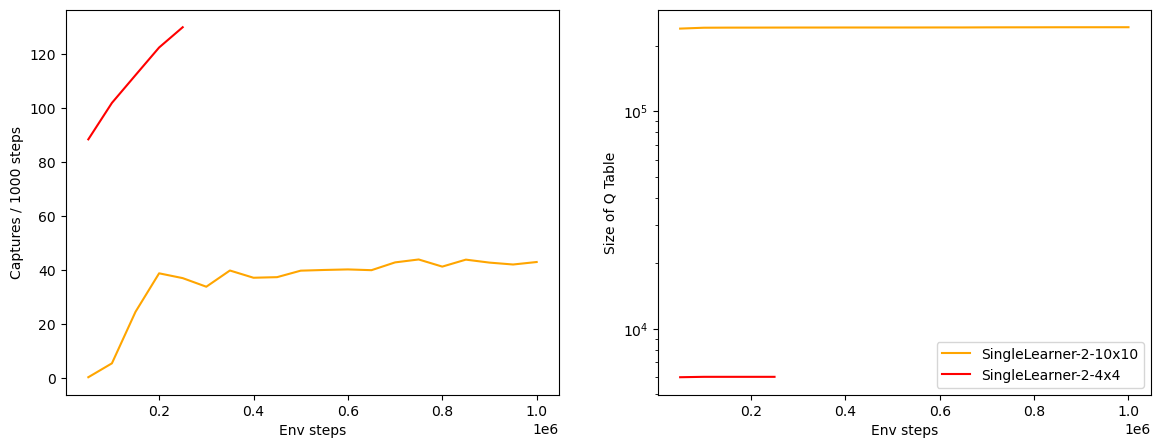

In [9]:
env = PredPrey(2, 4, 4)
run_experiment(env,
               TabularQLearner(env.possible_joint_actions),
               num_epochs=5, plot_rewards=True)
plot_all_results()

## Task 1d: Scaling of joint action learning
Let's revisit the size of the joint action space. 

Run the experiment with more agents, and observe how the size of the Q-Table increases. Notice the time per epoch increasing as well.

----- Start Learning with SingleLearner, 3 agents -----
Epoch 1: time = 4.44
Train: reward = 2.64 -- Captures/1000 = 124.22
Eval: reward = 4.90 -- Captures/1000 = 168.95
{'table_size': 367625}
Epoch 2: time = 4.28
Train: reward = 4.02 -- Captures/1000 = 147.70
Eval: reward = 5.17 -- Captures/1000 = 173.65
{'table_size': 382125}
Epoch 3: time = 5.36
Train: reward = 4.06 -- Captures/1000 = 149.26
Eval: reward = 4.99 -- Captures/1000 = 171.20
{'table_size': 389375}
Epoch 4: time = 5.04
Train: reward = 4.24 -- Captures/1000 = 152.60
Eval: reward = 5.25 -- Captures/1000 = 175.55
{'table_size': 396500}
Epoch 5: time = 4.86
Train: reward = 3.97 -- Captures/1000 = 147.60
Eval: reward = 5.11 -- Captures/1000 = 172.60
{'table_size': 400750}
----- Start Learning with SingleLearner, 4 agents -----
Epoch 1: time = 12.76
Train: reward = -1.33 -- Captures/1000 = 91.82
Eval: reward = 0.06 -- Captures/1000 = 126.10
{'table_size': 17721250}
Epoch 2: time = 10.49
Train: reward = 0.90 -- Captures/1000 = 1

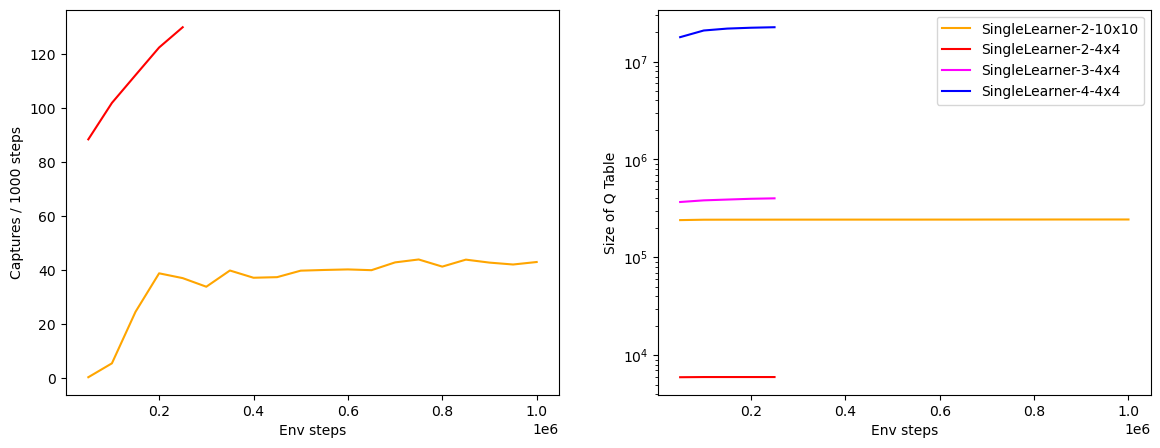

In [10]:
for n_agents in range(3, 5):
    env = PredPrey(n_agents, 4, 4)
    run_experiment(env,
                   TabularQLearner(env.possible_joint_actions),
                   num_epochs=5, plot_rewards=False)
plot_all_results()

# EXERCISE 2: Independent Q-Learning
In this exercise you will implement independent Q-Learning!
This will address the scaling of a joint action learner, and permit decentralised learning or execution of policies.

## TASK 2a: Build an interface for independent learners
Build a IndependentQLearner that manages several TabularQLearners!
This should be callable by the experiment, so it needs to return joint actions.
But instead of being backed by a single TabularQLearner, make it use one learner for each agent. Each agent can still see the full state. Also, answer the question there. 

In [11]:
class IndependentQLearner:
    """ Tabular Q-learning agent that manages one TabularQLearner per agent. """
    gamma = 0.9
    learn_rate = 0.2

    def __init__(self, env, agent_learner=TabularQLearner):
        """ Initialise one agent_learner instance for each environment agent. """
        self.name = f"IQL: {agent_learner.__name__}"
        self.n_agents = env.n_agents
        # create one learner per agent; each sees the full state and has the same action set
        self.learners = [agent_learner(env.possible_agent_actions) for _ in range(self.n_agents)]

    def sample(self, state, eps):
        """ Sample for each agent independently and return a joint action (tuple). """
        joint_action = tuple(learner.sample(state, eps) for learner in self.learners)
        return joint_action

    def value(self, state):
        """ Pourquoi on ne peut pas retourner une valeur unique ici ?
        Chaque agent a sa propre Q-table et la valeur d'un état dépend de la combinaison
        d'actions/joint-policy des autres agents. Il n'existe donc pas de valeur d'état
        unifiée pour l'apprentissage indépendant sans une règle d'agrégation explicite.
        """
        raise AssertionError("Impossible de retourner une valeur unique pour IQL (voir docstring).")

    def update(self, state, joint_action, reward, next_state, done):
        """ Update each agent's learner with the shared experience. """
        # joint_action est un tuple d'actions, une par agent
        for i, learner in enumerate(self.learners):
            learner.update(state, joint_action[i], reward, next_state, done)

    def stats(self):
        """ Return the sum (by key) of stats dicts for each learner. """
        from collections import defaultdict
        summed = defaultdict(float)
        for learner in self.learners:
            s = learner.stats()
            for k, v in s.items():
                summed[k] += v
        return dict(summed)

## TASK 2b: Test the independent Q-Learner
Run the independent Q-learner below. It should get some decent results, comparable to that of the joint-action learner. But the training should be more unstable.

**Question**: Why is IQL potentially unstable? Why might it not converge? How does exploration interact with learning?

IQL is unstable and may fail to converge because the multi-agent environment is **non-stationary**:

* **Non-Stationarity:** Each agent's changing policy constantly shifts the **transition and return distributions** observed by others. Q-learning requires a stationary MDP, but here, the bootstrap target is always moving.
* **Credit Assignment:** Shared collective rewards make it hard for an agent to attribute the outcome to its specific action, leading to **noisy updates**.
* **Exploration Impact:** Exploratory actions ($\epsilon$-greedy) by one agent drastically alter the observed environment for all others, preventing system-wide Q-value stabilization.

**Mitigation:** Use **Centralized Training/Decentralized Execution (CTDE)** or robust updates like **Hysteretic Q-learning**.

----- Start Learning with IQL: TabularQLearner, 2 agents -----
Epoch 1: time = 3.65
Train: reward = -0.17 -- Captures/1000 = 0.14
Eval: reward = -0.16 -- Captures/1000 = 0.30
{'table_size': 96010.0}
Epoch 2: time = 3.47
Train: reward = -0.14 -- Captures/1000 = 0.28
Eval: reward = -0.08 -- Captures/1000 = 0.95
{'table_size': 96990.0}
Epoch 3: time = 3.21
Train: reward = -0.03 -- Captures/1000 = 2.50
Eval: reward = 0.29 -- Captures/1000 = 10.80
{'table_size': 97060.0}
Epoch 4: time = 3.31
Train: reward = 0.60 -- Captures/1000 = 21.60
Eval: reward = 1.76 -- Captures/1000 = 51.95
{'table_size': 97110.0}
Epoch 5: time = 3.29
Train: reward = 1.06 -- Captures/1000 = 35.20
Eval: reward = 2.14 -- Captures/1000 = 63.50
{'table_size': 97130.0}
Epoch 6: time = 3.37
Train: reward = 1.35 -- Captures/1000 = 43.30
Eval: reward = 2.36 -- Captures/1000 = 68.60
{'table_size': 97140.0}
Epoch 7: time = 3.41
Train: reward = 1.34 -- Captures/1000 = 43.26
Eval: reward = 1.72 -- Captures/1000 = 50.50
{'table_s

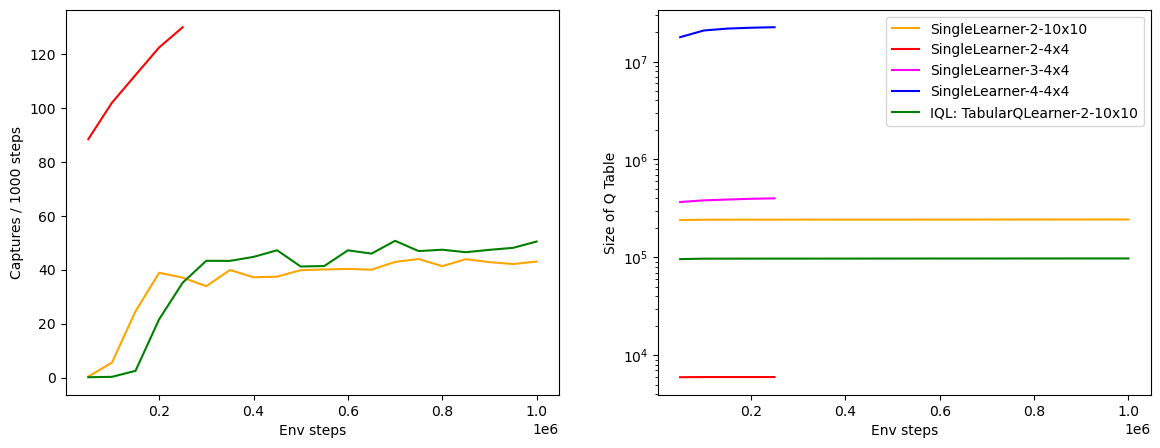

In [12]:
env = PredPrey(2, 10, 10)
run_experiment(env, IndependentQLearner(env), num_epochs=20)
plot_all_results()

----- Start Learning with IQL: TabularQLearner, 2 agents -----
Epoch 1: time = 4.40
Train: reward = 2.28 -- Captures/1000 = 91.70
Eval: reward = 3.49 -- Captures/1000 = 128.60
{'table_size': 2350.0}
Epoch 2: time = 4.64
Train: reward = 2.52 -- Captures/1000 = 101.30
Eval: reward = 4.11 -- Captures/1000 = 147.80
{'table_size': 2390.0}
Epoch 3: time = 3.83
Train: reward = 2.39 -- Captures/1000 = 99.26
Eval: reward = 2.75 -- Captures/1000 = 97.75
{'table_size': 2400.0}
Epoch 4: time = 3.58
Train: reward = 2.53 -- Captures/1000 = 100.16
Eval: reward = 1.99 -- Captures/1000 = 75.60
{'table_size': 2400.0}
Epoch 5: time = 3.54
Train: reward = 2.51 -- Captures/1000 = 102.48
Eval: reward = 3.69 -- Captures/1000 = 134.65
{'table_size': 2400.0}


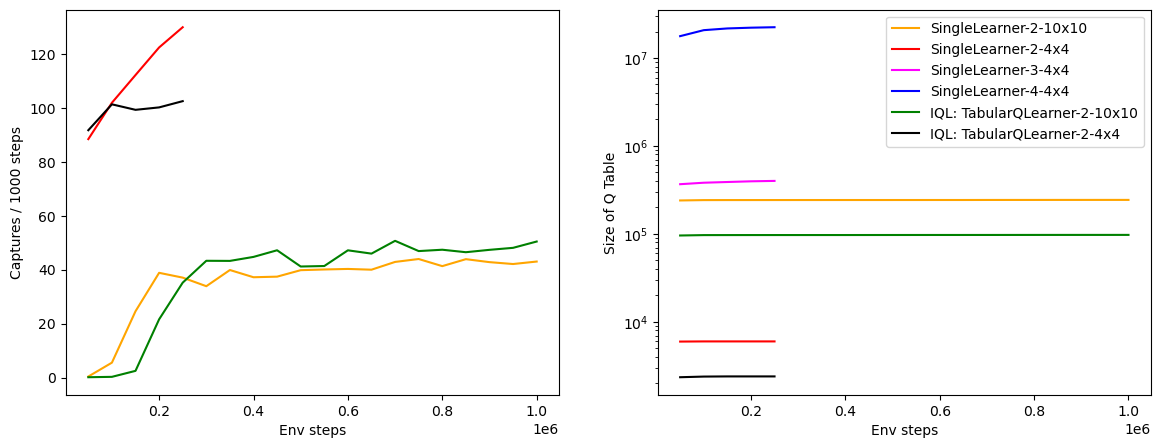

In [13]:
env = PredPrey(2, 4, 4)
run_experiment(env, IndependentQLearner(env), num_epochs=5)
plot_all_results()

## Task 2c: Investigate the scaling of IQL

Check how IQL compares to Joint-action Q-Learning in scaling up with more agents!

----- Start Learning with IQL: TabularQLearner, 3 agents -----
Epoch 1: time = 5.39
Train: reward = 2.20 -- Captures/1000 = 109.60
Eval: reward = 5.50 -- Captures/1000 = 181.40
{'table_size': 43860.0}
Epoch 2: time = 5.63
Train: reward = 3.81 -- Captures/1000 = 142.08
Eval: reward = 6.01 -- Captures/1000 = 195.10
{'table_size': 45270.0}
Epoch 3: time = 5.64
Train: reward = 4.22 -- Captures/1000 = 151.28
Eval: reward = 6.11 -- Captures/1000 = 193.90
{'table_size': 46410.0}
Epoch 4: time = 5.07
Train: reward = 4.35 -- Captures/1000 = 153.50
Eval: reward = 6.49 -- Captures/1000 = 201.50
{'table_size': 47295.0}
Epoch 5: time = 5.47
Train: reward = 4.41 -- Captures/1000 = 153.84
Eval: reward = 6.38 -- Captures/1000 = 198.90
{'table_size': 47880.0}
----- Start Learning with IQL: TabularQLearner, 4 agents -----
Epoch 1: time = 7.78
Train: reward = -1.38 -- Captures/1000 = 88.88
Eval: reward = 0.32 -- Captures/1000 = 124.30
{'table_size': 568340.0}
Epoch 2: time = 7.62
Train: reward = 0.66 -- 

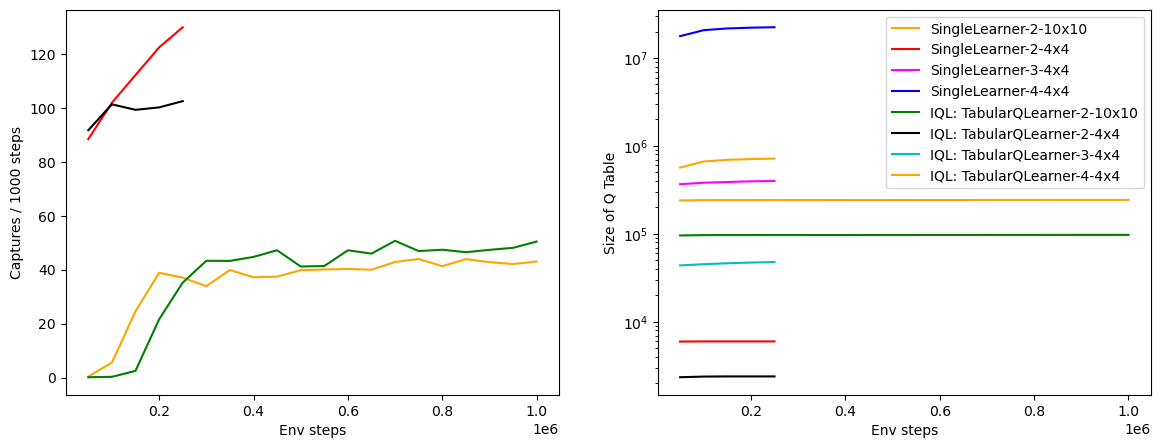

In [14]:
for n_agents in range(3, 5):
    env = PredPrey(n_agents, 4, 4)
    run_experiment(env,
                   IndependentQLearner(env),
                   num_epochs=5, plot_rewards=False)
plot_all_results()

# TASK 3: Hysteretic Q-Learning

## Task 3a: Re-invent hysteretic Q-Learning (with some hints)
Think about how exploration interacts with the values seen by the agents.
When one agent takes a greedy action but another explores, will the independent learner over- or under- estimate the optimal value of the state? Why? 

Under-estimate. When your partner explores, coordination fails and observed returns are lower than the true coordinated optimum, pushing Q down.

Given that, should we rather trust more high or low bootstrap estimates of the optimal value? Why? 

The higher ones. Low targets are often artifacts of miscoordination/exploration; high ones indicate successful coordination and are closer to the optimal value.

Imagine using a different learning rate for positive and negative TD-errors. Would this give us a way to implement the above idea?

Yes. Use a larger step for positive TD-errors and a smaller step for negative ones (the “hysteretic” update):

$$Q \leftarrow Q + \big(\mathbf{1}_{\delta\ge0}\alpha + \mathbf{1}_{\delta<0}\beta\big)\delta$$

with $\alpha > \beta$.

In this case, should the learning rate be higher or lower for postive or negative TD-errors?

Higher for positive TD-errors (α), lower for negative TD-errors (β). This preserves good estimates while damping pessimistic drops caused by partner exploration.

## Task 3a: Implement Hysteretic Q-Learning

Make a hysteretic Q-learner that subclasses the TabularQLearner.
Use the default learn_rate as the larger learning rate, and beta=0.01 as the smaller learning rate.

In [15]:
class HystereticQLearner(TabularQLearner):
    beta = 0.01
    
    def __init__(self, action_list):
        super(HystereticQLearner, self).__init__(action_list)
        self.name = "Hysteretic"

    def update(self, state, action, reward, next_state, done):
        """ This update uses a different learning rate for positive and negative TD-errors """
        not_done = 0 if done else 1
        td_error = reward + not_done * self.gamma * self.value(next_state) - self.q_table[state][action]
        # use larger learning rate (self.learn_rate) for positive TD-errors,
        # and smaller learning rate (self.beta) for non-positive TD-errors
        lr = self.learn_rate if td_error > 0 else self.beta
        self.q_table[state][action] += lr * td_error

## Task 3c: Test Hysteretic Q-Learning

Test the hysteretic Q-learner. If all goes well, it should outperform the other variants.
Think about why in retrospect.

----- Start Learning with IQL: HystereticQLearner, 2 agents -----
Epoch 1: time = 3.34
Train: reward = -0.17 -- Captures/1000 = 0.14
Eval: reward = -0.16 -- Captures/1000 = 0.30
{'table_size': 96010.0}
Epoch 2: time = 3.55
Train: reward = -0.13 -- Captures/1000 = 0.44
Eval: reward = -0.09 -- Captures/1000 = 0.95
{'table_size': 96940.0}
Epoch 3: time = 3.36
Train: reward = 0.03 -- Captures/1000 = 4.22
Eval: reward = 0.55 -- Captures/1000 = 18.35
{'table_size': 97040.0}
Epoch 4: time = 3.28
Train: reward = 0.63 -- Captures/1000 = 23.14
Eval: reward = 1.63 -- Captures/1000 = 50.10
{'table_size': 97080.0}
Epoch 5: time = 3.78
Train: reward = 1.14 -- Captures/1000 = 37.96
Eval: reward = 2.10 -- Captures/1000 = 61.65
{'table_size': 97120.0}
Epoch 6: time = 3.79
Train: reward = 1.24 -- Captures/1000 = 41.18
Eval: reward = 2.03 -- Captures/1000 = 61.10
{'table_size': 97150.0}
Epoch 7: time = 4.36
Train: reward = 1.30 -- Captures/1000 = 42.68
Eval: reward = 2.17 -- Captures/1000 = 64.15
{'table

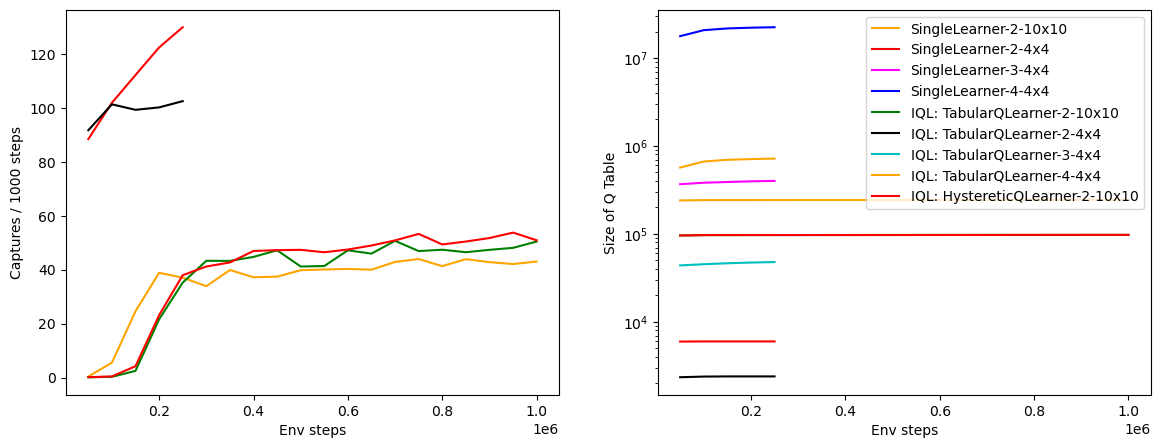

In [16]:
env = PredPrey(2, 10, 10)
run_experiment(env,
               IndependentQLearner(env, agent_learner=HystereticQLearner),
               num_epochs=20)
plot_all_results()

----- Start Learning with IQL: HystereticQLearner, 2 agents -----
Epoch 1: time = 3.63
Train: reward = 1.99 -- Captures/1000 = 84.94
Eval: reward = 3.69 -- Captures/1000 = 134.35
{'table_size': 2400.0}
Epoch 2: time = 3.63
Train: reward = 2.53 -- Captures/1000 = 104.56
Eval: reward = 4.14 -- Captures/1000 = 149.95
{'table_size': 2400.0}
Epoch 3: time = 3.92
Train: reward = 2.87 -- Captures/1000 = 116.76
Eval: reward = 4.29 -- Captures/1000 = 159.15
{'table_size': 2400.0}
Epoch 4: time = 4.08
Train: reward = 3.28 -- Captures/1000 = 132.50
Eval: reward = 5.00 -- Captures/1000 = 180.10
{'table_size': 2400.0}
Epoch 5: time = 4.23
Train: reward = 3.56 -- Captures/1000 = 142.86
Eval: reward = 5.44 -- Captures/1000 = 199.95
{'table_size': 2400.0}


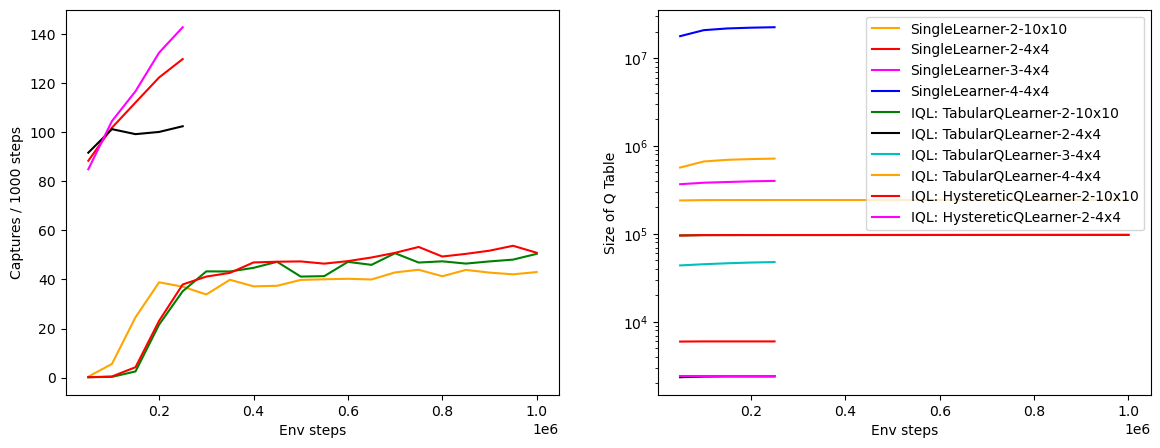

In [17]:
env = PredPrey(2, 4, 4)
run_experiment(env,
               IndependentQLearner(env, agent_learner=HystereticQLearner),
               num_epochs=5)
plot_all_results()

# (BONUS) Symmetry and Greed

There are a number of symmetries in this problem. How can we use them to learn faster or with fewer parameters?

(Parameter sharing between agents, spatial symmetries should reduce size of Q-table a lot)

Why is the greedy policy so bad in evaluation compared to the epsilon-greedy one? Is there a bug?

This practical has been based on the predator-prey environment and algorithms from this paper:
https://hal.archives-ouvertes.fr/hal-00187279/document